# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64\Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
# NOTE: Run this if you want to see random actions taken in the environment being used
# for i in range(1, 6):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### 5. Multi Agent DDPG Implementation
Train the intelligent agent using multiple agents.

In [7]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

n_episodes = 1000
max_t = 1000
window_size = 100

def ddpg(n_episodes=n_episodes, max_t=max_t, window_size=window_size):
    """Interact with the environment and learn with an agent
    
    Note: This implementation works with an environment that has 20 agents running in parallel.
          States and Actions are tensors of (agents, states/actions) or better thought of as
          (batch_size=20, *values*) for inference purposes. While traning it consists of
          the normal (training_batch_hyperparameter, *inputs*)

    """
    solved = False # flag for solved environment
    best_score = 0 # keep track of the best score
    
    # Agent that will be interacting with the environment
    agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)
    
    # Scores window for each episode, each score is an average of all agents for one episode
    scores_window = deque(maxlen=window_size)
    episode_scores = [] # record of all episode scores
    
    for i_episode in range(1, n_episodes+1):    
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment at the beginning of the episode (train mode)
        states = env_info.vector_observations # get the states (for each agent)
            
        # reset the modeled noise (for each agent)
        agent.reset()
        
        # Score for each agent
        scores = np.zeros(num_agents)
        
        # Start the time steps in the episode
        for t in range(max_t):
            # Choose completely random actions in the begining episodes
            if i_episode < 300:
                actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
                actions = np.clip(actions, -1, 1)              
            else:
                # Get actions to take using a deep nn model (for each agent)
                actions = agent.act(states)
            
            env_info = env.step(actions)[brain_name]         # take an action in the environment (for each agent)
            next_states = env_info.vector_observations       # get next states (for each agent)
            rewards = env_info.rewards                       # get rewards (for each agent)  
            dones = env_info.local_done                      # get episode termination status (for each agent)
            agent.step(states, actions, rewards, next_states, dones) # update the agent memory with the experiences and learn
            agent.update_t(t)
            states = next_states # move to next time step
            scores += rewards # record rewards (over each agent)
            
            # Check if any agent has terminated to end the episode
            if any(dones):
                break
        
        # Get the max agent score
        score = np.max(scores)
        
        # Add to the scores queue window, and episode scores list
        scores_window.append(score)
        episode_scores.append(score)
        
        # Compute the environment average score
        environment_average = np.mean(scores_window)
        
        # Print some score stats
        print('\rEpisode {}\tAgent Average Score: {:.2f}'.format(i_episode, score), end="")
        
        if i_episode % window_size == 0:
            print('\tEnvironment Average Score (100 episodes): {:.2f}'.format(environment_average))
        
            # See if we have passed the environment solved standard
            if environment_average >= 0.5 and len(scores_window) == 100 and not solved:
                print("Environment solved in {} episodes!".format(i_episode))
                print("Average environment score (100 episodes): {}".format(environment_average))

                # Save the model weights
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
                print('Models saved!')
                
                # Set some flags for further training
                best_score = environment_average
                solved = True
                continue
            
            # Find the BEST model if the environment is solved
            if solved and environment_average > best_score:
                # Save the model weights
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
                best_score = environment_average
                print('Improved model found! Models saved.')

    return episode_scores


scores = ddpg()

# Close out the environment
env.close()

Episode 11	Agent Average Score: 0.00

c:\users\fury\miniconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Agent Average Score: 0.10	Environment Average Score (100 episodes): 0.02
Episode 200	Agent Average Score: 0.00	Environment Average Score (100 episodes): 0.02
Episode 300	Agent Average Score: 0.00	Environment Average Score (100 episodes): 0.01
Episode 400	Agent Average Score: 0.00	Environment Average Score (100 episodes): 0.02
Episode 500	Agent Average Score: 0.10	Environment Average Score (100 episodes): 0.04
Episode 600	Agent Average Score: 0.10	Environment Average Score (100 episodes): 0.12
Episode 700	Agent Average Score: 0.10	Environment Average Score (100 episodes): 0.31
Episode 800	Agent Average Score: 0.09	Environment Average Score (100 episodes): 0.19
Episode 900	Agent Average Score: 0.00	Environment Average Score (100 episodes): 1.15
Environment solved in 900 episodes!
Average environment score (100 episodes): 1.1525000172108413
Models saved!
Episode 1000	Agent Average Score: 2.60	Environment Average Score (100 episodes): 1.29
Improved model found! Models saved.


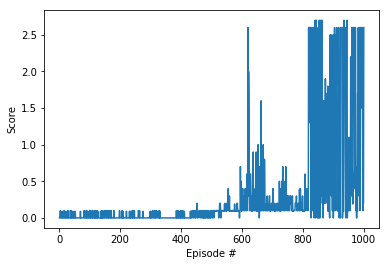

In [8]:
# Plot the training results
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [1]:
# NOTE: Restart the python kernel if there is a problem running this after running the above code
# Inference so we can see the model in action
import torch
from ddpg_agent import Agent
from unityagents import UnityEnvironment
import numpy as np
import random

env = UnityEnvironment(file_name='Tennis_Windows_x86_64\Tennis.exe')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment (inference mode)

num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

# Load the trained weights
agent = Agent(state_size=state_size, action_size=action_size, random_seed=random.random())
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))


states = env_info.vector_observations                  # get state state (for each agent)
scores = np.zeros(num_agents)                          # record scores (for each agent)

while True:
    actions = agent.act(states, add_noise=False)       # get actions to take for each agent (for each agent)
    env_info = env.step(actions)[brain_name]           # take an action in the environment (for each agent)
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # get episode termination status (for each agent)
    scores += rewards                         # record the rewards for each action (for each agent)
    states = next_states                               # move to the next time step
    
    if np.any(dones):                                  # check if any agent has terminated to end the episode
        break

print('Best Agent Score: {}'.format(np.max(scores)))

# Close out the environment
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 
c:\users\fury\miniconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Best Agent Score: 2.600000038743019
